In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

## Improve the data augmentation code. 

In [107]:
import torchvision.transforms.functional as F
import torchvision.transforms as T
import random
from PIL import Image, ImageEnhance, ImageFilter  
import numpy as np

class CustomTransform:
    def __init__(self, image_size=(480, 854), model_input_size=(448, 800), mean=None, std=None):
        self.image_size = image_size  # Final resized dimensions
        self.model_input_size = model_input_size   # Final cropped dimensions
        self.mean = mean if mean else [0.485, 0.456, 0.406]  # Default mean for ImageNet
        self.std = std if std else [0.229, 0.224, 0.225]    # Default std for ImageNet

    def __call__(self, img, mask, train_mode):
        if train_mode:
            # Resize to larger size for cropping
            img = F.resize(img, self.image_size)
            mask = F.resize(mask, self.image_size)

            # Random cropping occurs randomly.
            if random.random() > 0.5: 
                i, j, h, w = T.RandomCrop.get_params(img, output_size=self.model_input_size)
                img = F.crop(img, i, j, h, w)
                mask = F.crop(mask, i, j, h, w)

            # Random horizontal flip
            if random.random() > 0.5:
                img = F.hflip(img)
                mask = F.hflip(mask)

            # Random vertical flip
            if random.random() > 0.5:
                img = F.vflip(img)
                mask = F.vflip(mask)

            # Random brightness and contrast adjustments
            if random.random() > 0.5:
                enhancer = ImageEnhance.Brightness(img)
                img = enhancer.enhance(random.uniform(0.8, 1.2))  # Brightness adjustment
            if random.random() > 0.5:
                enhancer = ImageEnhance.Contrast(img)
                img = enhancer.enhance(random.uniform(0.8, 1.2))  # Contrast adjustment

            # Color jittering
            if random.random() > 0.5:
                img = F.adjust_hue(img, random.uniform(-0.05, 0.05))  # Slight hue change
                img = F.adjust_saturation(img, random.uniform(0.8, 1.2))  # Saturation change

            # Apply Gaussian blur
            if random.random() > 0.5:
                img = img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.5, 1.5)))
            
            # apply random noise    
            if random.random() > 0.5:
                img = self.add_noise(img)    
            
            # add specular reflection
            if random.random() > 0.5:
                img = self.add_specular_reflections(img) 
                       
        # Resize image and mask
        img = F.resize(img, self.model_input_size)
        mask = F.resize(mask, self.model_input_size) 
        
        # Convert to tensor
        img = F.to_tensor(img)
        mask = F.to_tensor(mask)  # Keeps the mask in [0, 1] range (binary)

        # Normalize image (mask should NOT be normalized)
        img = F.normalize(img, mean=self.mean, std=self.std)

        return img, mask

    @staticmethod
    def add_noise(img, max_intensity=0.3):
        """Apply random noise."""
        random_intensity = np.random.uniform(0, max_intensity)    
        img_np = np.array(img).astype(np.float32) / 255.0  # Normalize
        glare = np.random.uniform(0.0, random_intensity, img_np.shape)  # Create glare pattern
        reflection = np.minimum(img_np + glare, 1.0)  # Apply and clip
        return Image.fromarray((reflection * 255).astype(np.uint8))

    @staticmethod
    def add_specular_reflections(img, intensity=0.5, num_reflections=5, size_range=(1, 5)):
        """
        Simulates concentrated specular reflections in specific regions.
        
        Args:
            img (PIL.Image): Input image.
            intensity (float): Intensity of the specular reflections (0 to 1).
            num_reflections (int): Number of specular reflection spots to add.
            size_range (tuple): Range of sizes for the reflection spots (min_size, max_size).
        
        Returns:
            PIL.Image: Image with added specular reflections.
        """
        img_np = np.array(img).astype(np.float32) / 255.0  # Normalize the image
        h, w, _ = img_np.shape  # Get image dimensions

        # Create an empty mask for specular reflections
        reflection_mask = np.zeros((h, w), dtype=np.float32)

        for _ in range(num_reflections):
            # Randomly generate the position and size of each reflection
            center_x = random.randint(30, w - 30)
            center_y = random.randint(30, h - 30)
            radius_x = random.randint(size_range[0], size_range[1])  # Horizontal radius
            radius_y = random.randint(size_range[0], size_range[1])  # Vertical radius

            # Draw an elliptical reflection
            y, x = np.ogrid[:h, :w]
            mask = ((x - center_x) ** 2 / radius_x ** 2) + ((y - center_y) ** 2 / radius_y ** 2) <= 1
            reflection_mask[mask] += intensity  # Add intensity to the reflection region

        # Add the reflection mask to the image
        reflection_mask = np.clip(reflection_mask, 0, 1)  # Ensure valid range
        img_np += reflection_mask[:, :, None]  # Add mask to all channels
        img_np = np.clip(img_np, 0, 1)  # Ensure valid range after addition

        # Convert back to PIL.Image
        return Image.fromarray((img_np * 255).astype(np.uint8))


In [109]:
from collections import OrderedDict

In [110]:
task_class_frequencies = OrderedDict({
    "gallbladder": 10717,
    "liver": 3111,
    "cystic_duct": 2726,
    "null_target": 1245,
    "omentum": 1118,
    "cystic_artery": 846,
    "cystic_plate": 667,
    "fluid": 530,
    "specimen_bag": 386,
    "abdominal_wall_cavity": 166,
    "blood_vessel": 117,
    "adhesion": 81,
    "gut": 77,
    "cystic_pedicle": 59,
    "peritoneum": 50,
})

In [112]:
task_class_frequencies['gallbladder']

10717

(448, 800, 3)


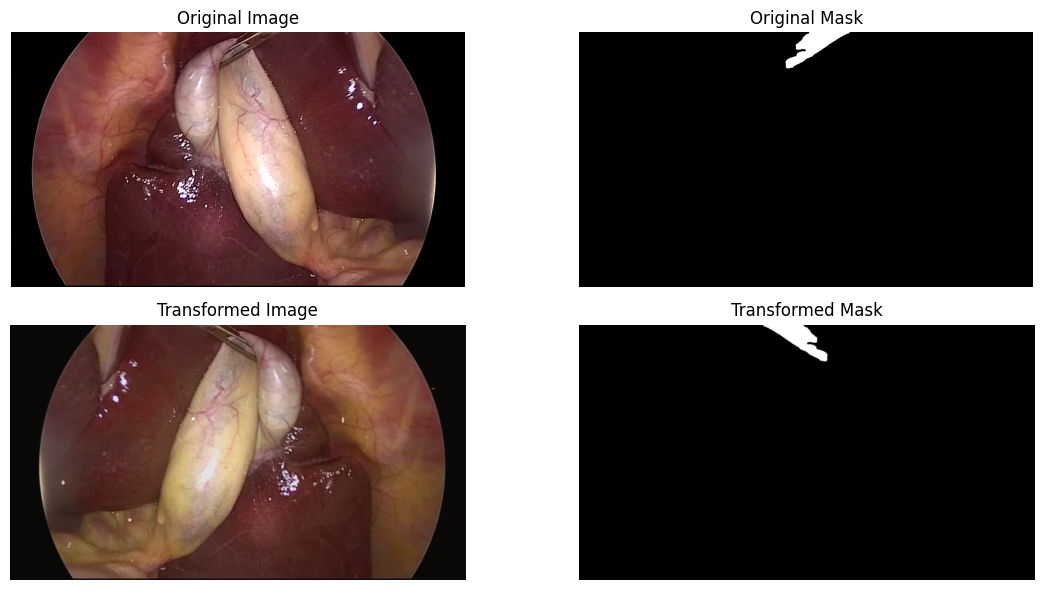

In [108]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Load a sample image and mask
image_path = "inputs/img_dir/t50_VID01_000000.png"  # Replace with the path to your input image
mask_path = "inputs/ann_dir/t50_VID01_000000,grasper,1,grasp,gallbladder.png"  # Replace with the path to your segmentation mask

original_image = Image.open(image_path).convert("RGB")
original_mask = Image.open(mask_path).convert("L")  # Assuming mask is grayscale

# Instantiate your transform
transform = CustomTransform(image_size=(480, 854 ), model_input_size=(448, 800))

# Test the transform
train_mode = True  # Set to True to apply all augmentations
transformed_image, transformed_mask = transform(original_image, original_mask, train_mode)

# Convert tensors back to images for visualization
transformed_image_np = np.transpose(transformed_image.numpy(), (1, 2, 0))  # (C, H, W) -> (H, W, C)
transformed_image_np = (transformed_image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))  # Unnormalize
transformed_image_np = np.clip(transformed_image_np, 0, 1)  # Ensure valid range

print(transformed_image_np.shape)
transformed_mask_np = transformed_mask.numpy().squeeze()  # Convert mask tensor to 2D numpy array

# Plot original and transformed images
plt.figure(figsize=(12, 6))

# Original image and mask
plt.subplot(2, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis("off")

plt.subplot(2, 2, 2)
plt.title("Original Mask")
plt.imshow(original_mask, cmap="gray")
plt.axis("off")

# Transformed image and mask
plt.subplot(2, 2, 3)
plt.title("Transformed Image")
plt.imshow(transformed_image_np)
plt.axis("off")

plt.subplot(2, 2, 4)
plt.title("Transformed Mask")
plt.imshow(transformed_mask_np, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()


In [88]:
# from PIL import Image
# import numpy as np
# import matplotlib.pyplot as plt


# def add_noise(img, max_intensity=0.3):
#     """Simulates reflections or glares with adjustable intensity."""
#     random_intensity = np.random.uniform(0, max_intensity)    
#     img_np = np.array(img).astype(np.float32) / 255.0  # Normalize
#     glare = np.random.uniform(0.0, random_intensity, img_np.shape)  # Create glare pattern
#     reflection = np.minimum(img_np + glare, 1.0)  # Apply and clip
#     return Image.fromarray((reflection * 255).astype(np.uint8))


# from PIL import Image, ImageDraw
# import numpy as np
# import random


# def add_specular_reflections(img, intensity=0.5, num_reflections=5, size_range=(1, 5)):
#     """
#     Simulates concentrated specular reflections in specific regions.
    
#     Args:
#         img (PIL.Image): Input image.
#         intensity (float): Intensity of the specular reflections (0 to 1).
#         num_reflections (int): Number of specular reflection spots to add.
#         size_range (tuple): Range of sizes for the reflection spots (min_size, max_size).
    
#     Returns:
#         PIL.Image: Image with added specular reflections.
#     """
#     img_np = np.array(img).astype(np.float32) / 255.0  # Normalize the image
#     h, w, _ = img_np.shape  # Get image dimensions

#     # Create an empty mask for specular reflections
#     reflection_mask = np.zeros((h, w), dtype=np.float32)

#     for _ in range(num_reflections):
#         # Randomly generate the position and size of each reflection
#         center_x = random.randint(30, w - 30)
#         center_y = random.randint(30, h - 30)
#         radius_x = random.randint(size_range[0], size_range[1])  # Horizontal radius
#         radius_y = random.randint(size_range[0], size_range[1])  # Vertical radius

#         # Draw an elliptical reflection
#         y, x = np.ogrid[:h, :w]
#         mask = ((x - center_x) ** 2 / radius_x ** 2) + ((y - center_y) ** 2 / radius_y ** 2) <= 1
#         reflection_mask[mask] += intensity  # Add intensity to the reflection region

#     # Add the reflection mask to the image
#     reflection_mask = np.clip(reflection_mask, 0, 1)  # Ensure valid range
#     img_np += reflection_mask[:, :, None]  # Add mask to all channels
#     img_np = np.clip(img_np, 0, 1)  # Ensure valid range after addition

#     # Convert back to PIL.Image
#     return Image.fromarray((img_np * 255).astype(np.uint8))


# # Load a sample image
# image_path = "inputs/img_dir/t50_VID01_000000.png"  # Replace with the path to your image
# original_image = Image.open(image_path).convert("RGB")

# # Apply noise with intensity in the range 0.1 to 0.3
# noisy_image = add_noise(original_image, max_intensity=0.3)

# #apply specular reflections
# specular_image = add_specular_reflections(
#     noisy_image, intensity=0.8, num_reflections=5, size_range=(1, 5)
# )


# # Plot the results
# plt.figure(figsize=(12, 6))

# # Original Image
# plt.subplot(1, 2, 1)
# plt.title("Original Image")
# plt.imshow(original_image)
# plt.axis("off")

# # Noisy Image
# plt.subplot(1, 2, 2)
# plt.title("Add Noise (0.1 to 0.3 Intensity Range)")
# plt.imshow(specular_image)
# plt.axis("off")

# plt.tight_layout()
# plt.show()
